In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [8]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")


In [9]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\roddi\AppData\Local\Temp\ipykernel_33280\3555078317.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [10]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['station', 'measurement']


In [11]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create a session
session = Session(engine)


# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

most_recent_date

'2017-08-23'

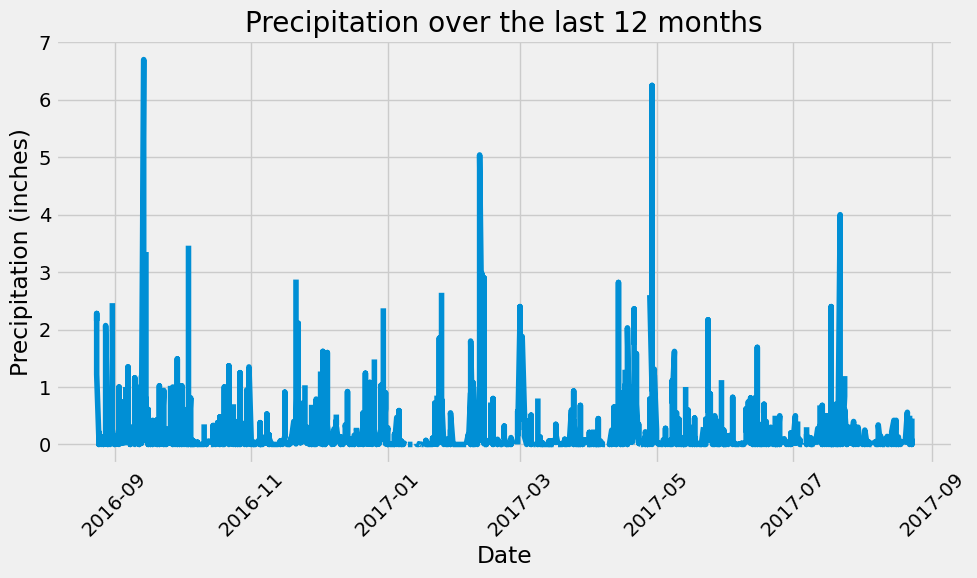

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])


# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['precipitation'])
plt.title('Precipitation over the last 12 months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(df['precipitation'].describe())

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {station_count}")

Total number of stations: 9


In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("Most active stations:")
for station, count in most_active_stations:
    print(f"Station {station}: {count} observations")

Most active stations:
Station USC00519281: 2772 observations
Station USC00519397: 2724 observations
Station USC00513117: 2709 observations
Station USC00519523: 2669 observations
Station USC00516128: 2612 observations
Station USC00514830: 2202 observations
Station USC00511918: 1979 observations
Station USC00517948: 1372 observations
Station USC00518838: 511 observations


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(f"\nTemperature stats for most active station {most_active_station}:")
print(f"Lowest temperature: {temp_stats[0][0]}")
print(f"Highest temperature: {temp_stats[0][1]}")
print(f"Average temperature: {temp_stats[0][2]:.2f}")


Temperature stats for most active station USC00519281:
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66


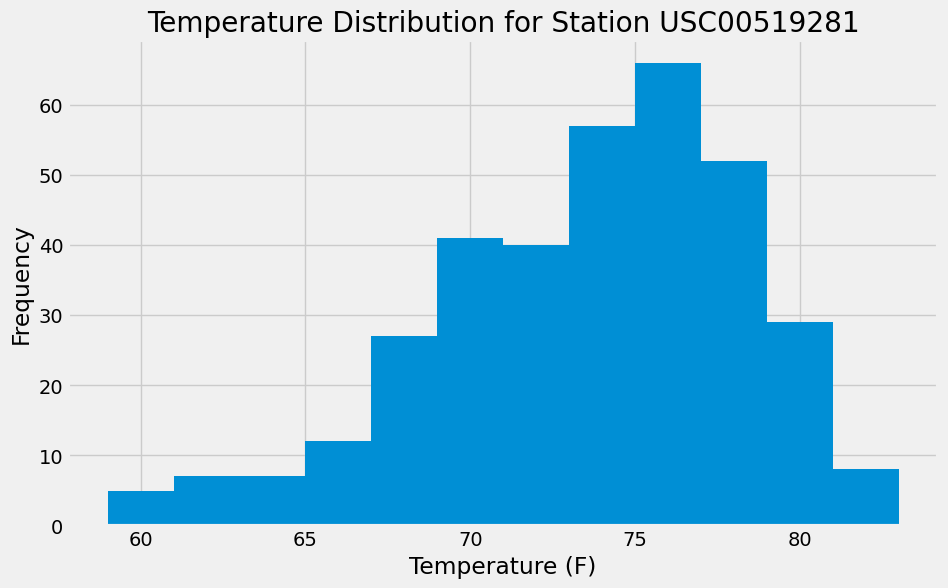

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

temp_df = pd.DataFrame(temp_data, columns=['temperature'])

plt.figure(figsize=(10,6))
plt.hist(temp_df['temperature'], bins=12)
plt.title(f'Temperature Distribution for Station {most_active_station}')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [25]:
# Close Session
session.close()
